# About

These is a base solution of PID.

In [4]:
%matplotlib inline
import random
import pandas
import numpy
import cPickle as pickle
import matplotlib.pyplot as plt

import root_numpy
from sklearn.metrics import roc_auc_score, roc_curve

from rep.estimators import XGBoostClassifier, SklearnClassifier

from sklearn.ensemble import ExtraTreesClassifier
from rep.estimators import XGBoostClassifier, SklearnClassifier
from rep.metaml import FoldingClassifier

# Directories

In [5]:
track = 'Long'
particle = 'Electron'

data_path = "../../../data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/\
GhostAccFrac1.0/TMVA-Run2-NoTkLikCD/Long"

work_path = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/" + \
"multiclass/Long/XGBoost"

netconfig_path = "../../../data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
+ particle + "_Long_ANN.txt"

# Read data

In [6]:
particle_pdg_codes = {"all": 999999,
                    "Ghost": 0,
                    "Electron": 11,
                    "Muon": 13,
                    "Pion": 211,
                    "Kaon": 321,
                    "Proton": 2212}

particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]
labs = [0, 1, 2, 3, 4, 5]

In [60]:
data = pandas.read_csv(data_path + "/data_train.csv")

In [61]:
mc_p_type = numpy.abs(data.MCParticleType.values)
labels = numpy.zeros(len(mc_p_type))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels += one_lab * (mc_p_type == pdg)
    
numpy.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

# Balance data

In [62]:
for i in numpy.unique(labels):
    print "Size of class %d is " % i, (labels == i).sum()

Size of class 0 is  170119
Size of class 1 is  5610
Size of class 2 is  29839
Size of class 3 is  774220
Size of class 4 is  138261
Size of class 5 is  81951


In [63]:
selected_indexes = []

numpy.random.seed = 42

for i in numpy.unique(labels):
    
    indxs = numpy.random.choice(data.index[labels == i], 
                                size=min(50000, len(labels[labels == i])), 
                                replace=False)
    
    selected_indexes += list(indxs)

In [64]:
data.loc[selected_indexes].to_csv(data_path + "/data_train_balanced.csv")

# Read balanced data

In [7]:
data = pandas.read_csv(data_path + "/data_train_balanced.csv", index_col=0)

In [8]:
mc_p_type = numpy.abs(data.MCParticleType.values)
labels = numpy.zeros(len(mc_p_type))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels += one_lab * (mc_p_type == pdg)
    
numpy.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

In [9]:
for i in numpy.unique(labels):
    print "Size of class %d is " % i, (labels == i).sum()

Size of class 0 is  50000
Size of class 1 is  5610
Size of class 2 is  29839
Size of class 3 is  50000
Size of class 4 is  50000
Size of class 5 is  50000


# Features

In [10]:
# All allowable features
features = ['VeloCharge', 'BremPIDe', 'CaloNeutralPrs', 'CaloNeutralSpd', 'InAccBrem', 'InAccSpd', 'CaloPrsE',
            'InAccPrs', 'HcalPIDe', 'CaloHcalE', 'InAccHcal', 'CaloTrajectoryL', 'EcalPIDe', 'CaloNeutralEcal',
            'CaloTrMatch', 'CaloElectronMatch', 'CaloChargedPrs', 'CaloChargedSpd', 'MuonNShared', 'CaloBremMatch',
            'MuonIsLooseMuon', 'MuonIsMuon', 'MuonBkgLL', 'InAccEcal', 'MuonMuLL', 'TrackMatchChi2', 
            'TrackGhostProbability','EcalPIDmu', 'TrackPt', 'TrackP', 'NumProtoParticles', 'RichAboveMuThres',
            'NumCaloHypos', 'InAccMuon', 'TrackChi2PerDof', 'TrackNumDof', 'NumUpstreamTracks', 'NumLongTracks',
            'NumDownstreamTracks', 'CaloEcalChi2', 'NumRich1Hits', 'NumMuonTracks', 'CombDLLmu', 'CaloSpdE',
            'PrsPIDe', 'HcalPIDmu', 'NumSPDHits', 'NumVeloTracks', 'NumTTracks', 'TrackFitMatchChi2', 'CombDLLpi',
            'RichDLLbt', 'RichDLLpi', 'TrackCloneDist', 'TrackFitVeloNDoF', 'NumPVs', 'CombDLLp', 'TrackFitTChi2',
            'TrackFitTNDoF', 'RichAboveElThres', 'RichUsedAero', 'TrackDOCA', 'RichDLLe', 'TrackLikelihood',
            'CombDLLe', 'CombDLLk', 'CaloClusChi2', 'TrackFitVeloChi2', 'RichDLLp', 'RichUsedR1Gas', 'CaloBremChi2',
            'RichUsedR2Gas', 'CaloEcalE', 'RichAbovePiThres', 'CaloChargedEcal', 'NumRich2Hits', 'RichAboveKaThres',
            'RichAbovePrThres', 'RichDLLmu', 'RichDLLk']

# Features generation and selection

In [11]:
weights = numpy.zeros(len(labels))

for one_lab in labs:
    
    weights += 0.01*(labels == one_lab) * len(labels) / ((labels == one_lab).sum())
    
numpy.unique(weights)

array([ 0.0470898 ,  0.07890646,  0.41969519])

In [12]:
for i in numpy.unique(labels):
    print "Weight of class %d is " % i, weights[labels == i][0]

Weight of class 0 is  0.0470898
Weight of class 1 is  0.419695187166
Weight of class 2 is  0.0789064646939
Weight of class 3 is  0.0470898
Weight of class 4 is  0.0470898
Weight of class 5 is  0.0470898


In [13]:
from sklearn.cross_validation import train_test_split

train_inds, test_inds, labels_train, labels_test, weights_train, weights_test = train_test_split(data.index, 
                                                                                                 labels, 
                                                                                                 weights, 
                                                                                                 test_size=0.25, 
                                                                                                 random_state=42)

In [14]:
def get_feature_importances(new_features):
    
    sk_features = [u'CombDLLe', u'TrackGhostProbability', u'MuonIsMuon', u'MuonBkgLL',
                   u'CombDLLk', u'RichDLLk', u'MuonIsLooseMuon', u'MuonMuLL', u'CombDLLp',
                   u'RichDLLe', u'RichDLLp', u'RichDLLbt', u'CombDLLmu',
                   u'TrackChi2PerDof', u'TrackLikelihood', u'EcalPIDe',
                   u'RichAboveKaThres', u'TrackFitMatchChi2', u'PrsPIDe', u'RichDLLmu']
    
    forest = ExtraTreesClassifier(n_estimators=100, random_state=0, n_jobs=4, min_samples_leaf=1)
    sk = SklearnClassifier(forest, features=sk_features + new_features)
    
    sk.fit(data.loc[train_inds], labels_train, sample_weight=weights_train)
    
    imp = sk.get_feature_importances()
    
    return imp.loc[new_features]

In [15]:
10**-6

1e-06

In [ ]:
%%time

outputs = []
counter = 0

for one_num, one_feature in enumerate(features):
    for two_num, two_feature in enumerate(features):
        
        if one_num >= two_num:
            continue
        
        data[one_feature + '_add_' + two_feature] = data[one_feature].values + data[two_feature].values
        data[one_feature + '_sub_' + two_feature] = data[one_feature].values - data[two_feature].values
        data[one_feature + '_mul_' + two_feature] = data[one_feature].values * data[two_feature].values
        data[one_feature + '_div_' + two_feature] = data[one_feature].values / \
                                                    (data[two_feature].values + 10**-6)
        
        data[one_feature + '_add2_' + two_feature] = data[one_feature].values**2 + data[two_feature].values**2
        data[one_feature + '_sub2_' + two_feature] = data[one_feature].values**2 - data[two_feature].values**2
        
        
        new_features = []
        new_features += [one_feature + '_add_' + two_feature]
        new_features += [one_feature + '_sub_' + two_feature]
        new_features += [one_feature + '_mul_' + two_feature]
        new_features += [one_feature + '_div_' + two_feature]
        new_features += [one_feature + '_add2_' + two_feature]
        new_features += [one_feature + '_sub2_' + two_feature]
        
        out = get_feature_importances(new_features)
        outputs.append(out)
        
        data.drop(new_features, axis=1, inplace=True)
        
        counter += 1
        if counter % 100 == 0:
            print counter

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from rep.estimators import XGBoostClassifier, SklearnClassifier
from rep.metaml import FoldingClassifier

sk_features = [u'CombDLLe', u'TrackGhostProbability', u'MuonIsMuon', u'MuonBkgLL',
               u'CombDLLk', u'RichDLLk', u'MuonIsLooseMuon', u'MuonMuLL', u'CombDLLp',
               u'RichDLLe', u'RichDLLp', u'RichDLLbt', u'CombDLLmu',
               u'TrackChi2PerDof', u'TrackLikelihood', u'EcalPIDe',
               u'RichAboveKaThres', u'TrackFitMatchChi2', u'PrsPIDe', u'RichDLLmu']

forest = ExtraTreesClassifier(n_estimators=1000, random_state=0, n_jobs=4, min_samples_split=2)
sk = SklearnClassifier(forest, features=features)

#rfecv = MyRFECV(estimator=forest, step=None, cv=2, features=features)

sk.fit(data.loc[train_inds], labels_train, sample_weight=weights_train)


In [ ]:
imp = sk.get_feature_importances()

In [ ]:
imp = imp.sort(columns=['effect'], ascending=False)

In [ ]:
x = range(len(features))

plt.figure(figsize=(15,5))
plt.bar(x, imp.effect.values)
plt.xticks(x, imp.index, rotation=90, size=10)
plt.show()

In [ ]:
imp.index[:20]

In [ ]:
len(outputs)

In [ ]:
df_outputs = pandas.concat(outputs)

In [15]:
df_outputs = pandas.read_csv(work_path + '/feature_importances1.csv', index_col=0)

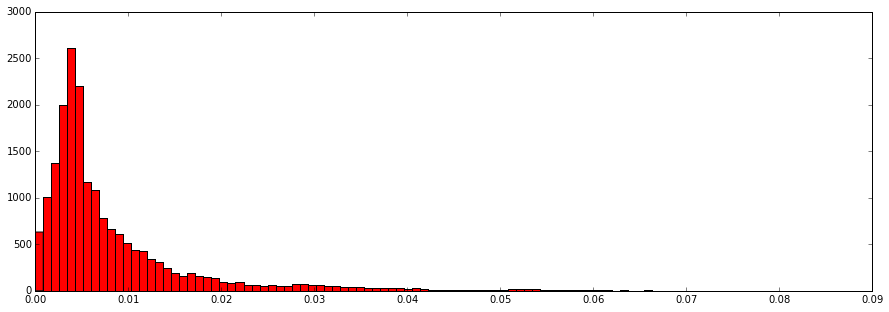

In [16]:
plt.figure(figsize=(15,5))
plt.hist(df_outputs.effect.values, bins=100)
plt.show()

In [17]:
df_outputs.sort(columns=['effect'], inplace=True, ascending=False)

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [18]:
#df_outputs.to_csv(work_path + '/feature_importances1.csv')
#df_outputs.to_csv(work_path + '/feature_importances2.csv')

In [19]:
p_cut = numpy.percentile(df_outputs.effect.values, 99)
p_cut

0.048351384583527002

In [20]:
df_sel_outputs = df_outputs[df_outputs.effect.values >= 0.06]

In [21]:
new_features = df_sel_outputs.index
len(new_features)

52

# Add new features

In [22]:
def add_new_features(data, features):

    for feature in new_features:
        [one_feature, operation, two_feature] = feature.split('_')
        
        if operation == 'add':
            
            data[feature] = data[one_feature].values + data[two_feature].values
            
        elif operation == 'sub':
            
            data[feature] = data[one_feature].values - data[two_feature].values
            
        elif operation == 'mul':
            
            data[feature] = data[one_feature].values * data[two_feature].values
            
        elif operation == 'div':
            
            data[feature] = data[one_feature].values / (data[two_feature].values + 10**-6)
            
        elif operation == 'add2':
            
            data[feature] = data[one_feature].values**2 + data[two_feature].values**2
            
        elif operation == 'sub2':
            
            data[feature] = data[one_feature].values**2 - data[two_feature].values**2
            
    return 1

In [23]:
add_new_features(data, new_features)

1

# Train XGBoost

In [ ]:
%%time

clf = XGBoostClassifier(n_estimators=2000, 
                        colsample=0.7, 
                        eta=0.01, 
                        nthreads=4, 
                        subsample=0.5, 
                        max_depth=8,
                        min_child_weight = 50,
                        features=features + list(new_features))

clf.fit(data.loc[train_inds], labels_train, sample_weight=weights_train)

# Feature importances

In [39]:
importances_dict = clf.xgboost_classifier.get_fscore()

In [40]:
importances_named = {}
for num, feature in enumerate(features+list(new_features)):
    
    if str(num) in importances_dict.keys():
        importances_named[feature] = importances_dict[str(num)]

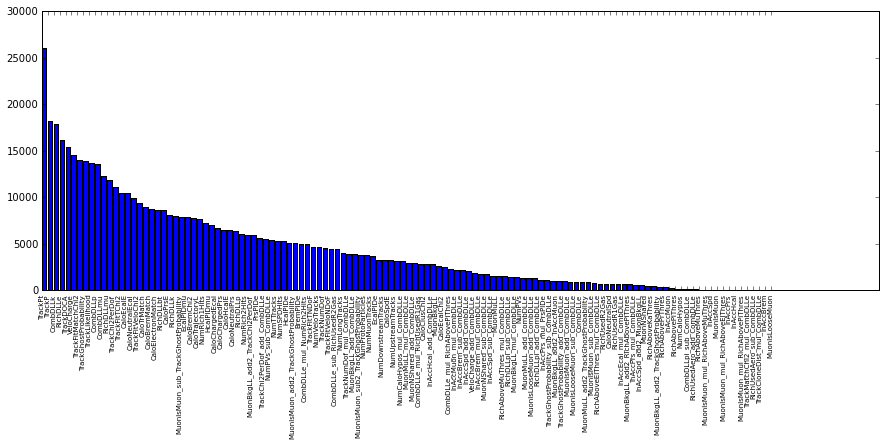

In [41]:
x = range(len(importances_named))
values = numpy.array(importances_named.values())
keys = numpy.array(importances_named.keys())


plt.figure(figsize=(15,5))
plt.bar(x, values[values.argsort()[::-1]])
plt.xticks(x, keys[values.argsort()[::-1]], rotation=90, size=7)
plt.show()

# Save the classifier

In [ ]:
params = clf.get_params()
params_str = ""
for key, val in zip(params.keys(), params.values()):
    if key != "features":
        params_str += key + "=" + str(val) + ";"

In [ ]:
new_work_path = work_path + "/" + params_str + 'balanced_data_' + str(len(data)) + 'new_features'
new_work_path

In [ ]:
# Save classifier
import os
if not os.path.exists(new_work_path):
    os.makedirs(new_work_path)

clf_pickle = open(new_work_path + '/classifier.pkl', 'wb')
pickle.dump(clf, clf_pickle)
clf_pickle.close()

In [14]:
# new_work_path = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/\
# multiclass/Long/XGBoost/verbose=0;missing=-999.0;scale_pos_weight=1.0;random_state=0;num_feature=None;\
# base_score=0.5;n_estimators=1000;subsample=0.5;eta=0.01;min_child_weight=50;colsample=0.7;max_depth=8;\
# gamma=None;nthreads=4;balanced_data_235449new_features"

In [15]:
# Read classifier
# clf_pickle2 = open(new_work_path + '/classifier.pkl', 'rb')
# clf = pickle.load(clf_pickle2)
# clf_pickle2.close()

# Test the classifier

In [ ]:
%%time
probas = clf.predict_proba(data.loc[test_inds])

In [ ]:
probas[:5, :]

### Logloss

In [37]:
from sklearn.metrics import log_loss

log_loss(labels_test, probas)

0.63722849633725576

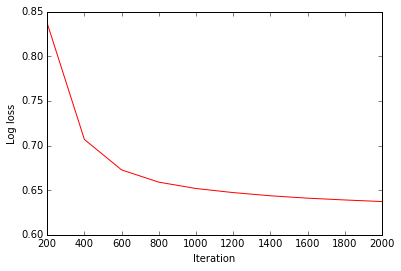

In [38]:

step = clf.get_params()['n_estimators'] / 10
staged_probas = clf.staged_predict_proba(data.loc[test_inds], step=step)

from sklearn.metrics import log_loss
log_loss_all = []
for pred in staged_probas:
    log_loss_all.append(log_loss(labels_test, pred))

x = numpy.arange(step, clf.get_params()['n_estimators'] + step, step)
plt.plot(x, log_loss_all)
plt.ylabel('Log loss')
plt.xlabel('Iteration')
plt.show()

### Roc curves

In [ ]:
import os, sys
sys.path.append('../python')
import utils

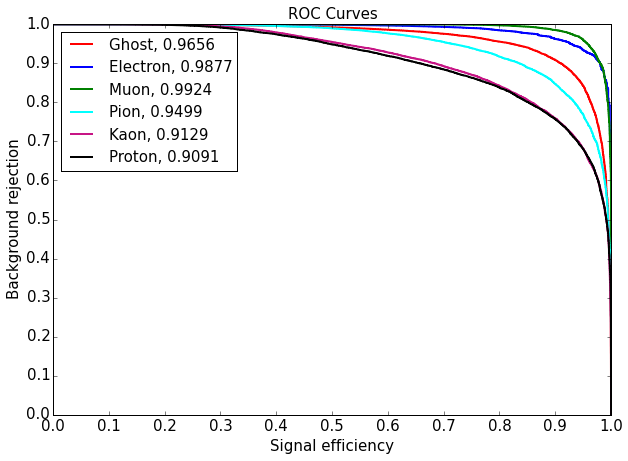

In [43]:
utils.get_roc_curves(labels_test, probas, particles, save_path=None, show=True)

# Evaluation

In [44]:
import os, sys
sys.path.append('../python')
import utils

In [45]:
data_eval = pandas.read_csv(data_path + "/data_eval.csv")

In [46]:
add_new_features(data_eval, new_features)

1

In [47]:
mc_p_type_eval = numpy.abs(data_eval.MCParticleType.values)
labels_eval = numpy.zeros(len(mc_p_type_eval))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels_eval += one_lab * (mc_p_type_eval == pdg)
    
numpy.unique(labels_eval)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

In [48]:
%%time
proba_eval = clf.predict_proba(data_eval)

CPU times: user 2h 8min 20s, sys: 8.45 s, total: 2h 8min 29s
Wall time: 33min 55s


In [21]:
#numpy.savetxt(new_work_path + '/xgboost_proba_eval.csv', proba_eval)

In [22]:
#proba_eval = numpy.loadtxt(new_work_path + '/xgboost_proba_eval.csv')

In [59]:
proba_eval[:5, :]

array([[  1.85916794e-03,   2.90057086e-03,   4.30180365e-03,
          4.69858386e-03,   9.04941931e-02,   8.95745695e-01],
       [  2.50142999e-03,   4.54367342e-04,   2.36496242e-04,
          8.58026790e-04,   4.15746897e-01,   5.80202758e-01],
       [  1.33921700e-02,   9.71164045e-05,   2.83605256e-03,
          9.58363473e-01,   1.27691580e-02,   1.25420010e-02],
       [  2.91271925e-01,   4.67891619e-02,   5.77772595e-03,
          4.67156410e-01,   9.76718515e-02,   9.13329348e-02],
       [  1.05181532e-02,   9.12085525e-05,   5.45443851e-04,
          9.85748351e-01,   1.61605352e-03,   1.48083153e-03]], dtype=float32)

### Get all figures from baseline

In [18]:
from get_figures import all_figures

In [19]:
for num in range(0, len(particles)):
        
    one_particle = particles[num]
    one_lab = labs[num]

    one_labels = (labels_eval == one_lab)*1
    one_probas = numpy.concatenate((1.-proba_eval[:, num].reshape(-1,1), proba_eval[:, num].reshape(-1,1)),axis=1)
    
    params = {}
    params['PARTICLE'] = one_particle
    params['TRACK'] = 'Long'
    
    all_figures(params, data_eval, one_probas, one_labels, features, path= new_work_path + "/"+ one_particle +"/pic")

### Logloss

In [60]:
from sklearn.metrics import log_loss

logloss = log_loss(labels_eval, proba_eval)
logloss

0.63300167039241306

### Roc curves, roc auc matrix and roc auc ratio matrix

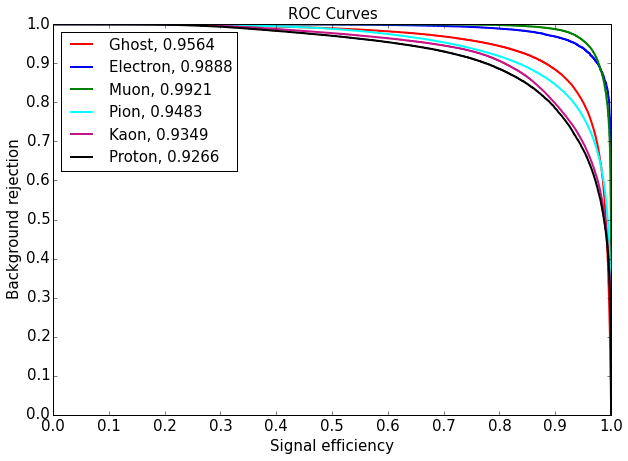

In [61]:
utils.get_roc_curves(labels_eval, proba_eval, particles, save_path=new_work_path, show=True)

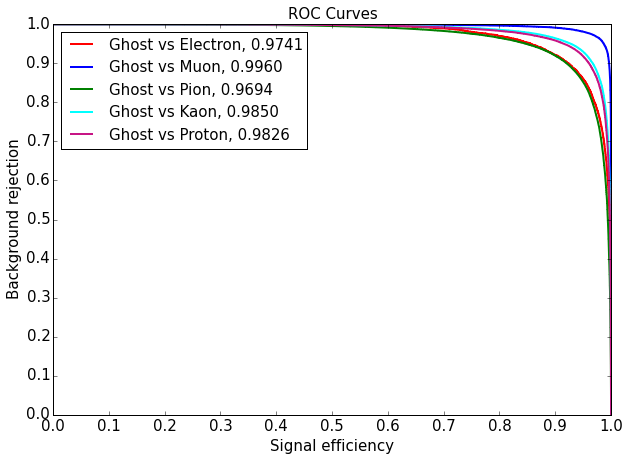

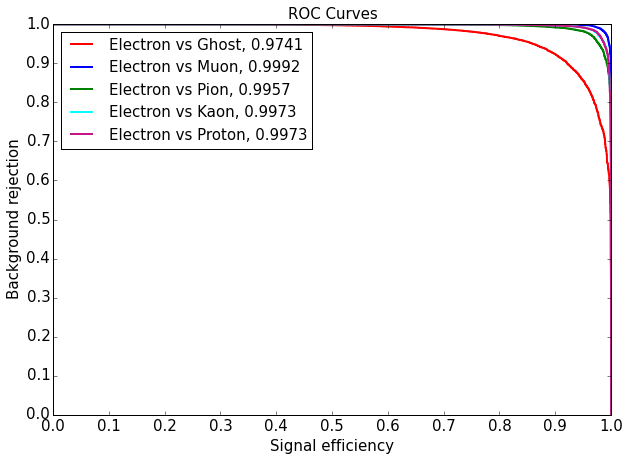

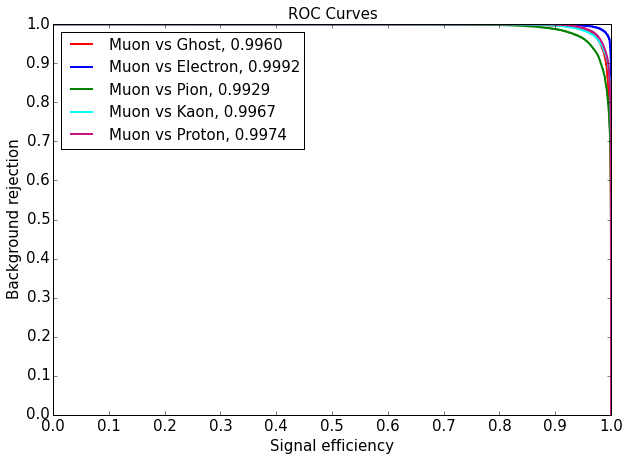

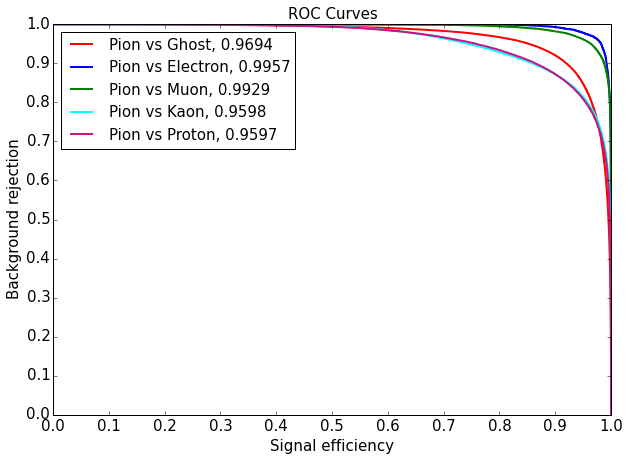

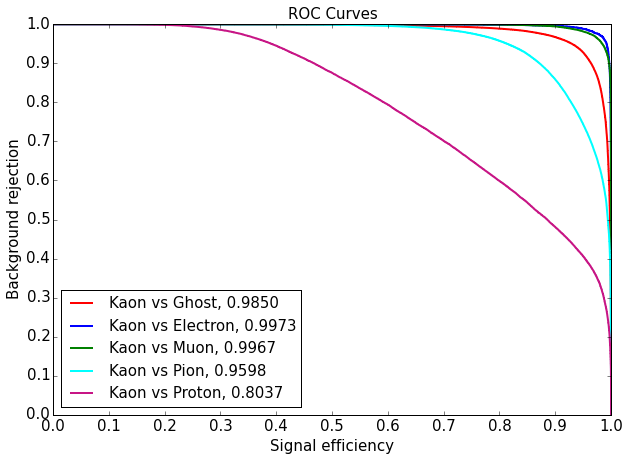

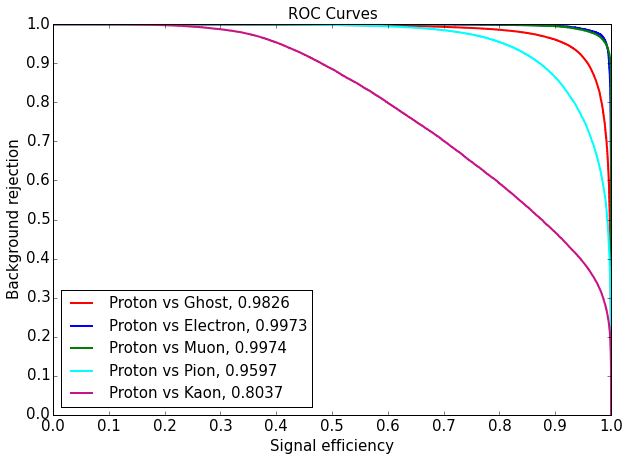

In [62]:
utils.get_one_vs_one_roc_curves(labels_eval, proba_eval, particles, save_path=new_work_path, show=True)

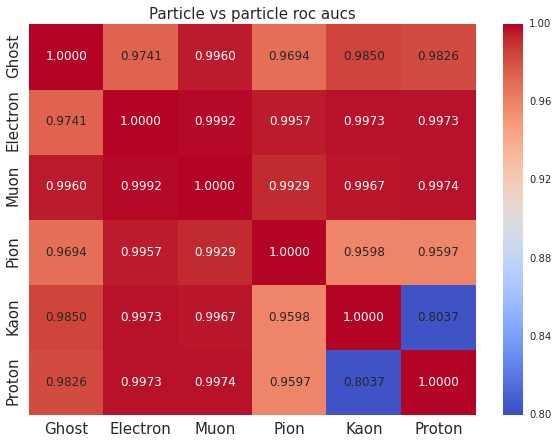

,Ghost,Electron,Muon,Pion,Kaon,Proton
Ghost,1.000000,0.974105,0.996025,0.969354,0.984964,0.982609
Electron,0.974105,1.000000,0.999163,0.995717,0.997293,0.997340
Muon,0.996025,0.999163,1.000000,0.992854,0.996701,0.997413
Pion,0.969354,0.995717,0.992854,1.000000,0.959787,0.959677
Kaon,0.984964,0.997293,0.996701,0.959787,1.000000,0.803675
Proton,0.982609,0.997340,0.997413,0.959677,0.803675,1.000000


In [63]:
roc_auc_matrix = utils.get_roc_auc_matrix(labels_eval, proba_eval, particles, save_path=new_work_path, show=True)
roc_auc_matrix

In [64]:
roc_auc_matrix_baseline = pandas.read_csv("../python/class_vs_class_roc_auc_matrix_baseline.csv", index_col=0)

In [65]:
mean = 0
for one in range(0, 6):
    for two in range(0, 6):
        if one >= two:
            continue
        mean += roc_auc_matrix.iloc[one, two] / 15
        
mean

0.97377849968778163

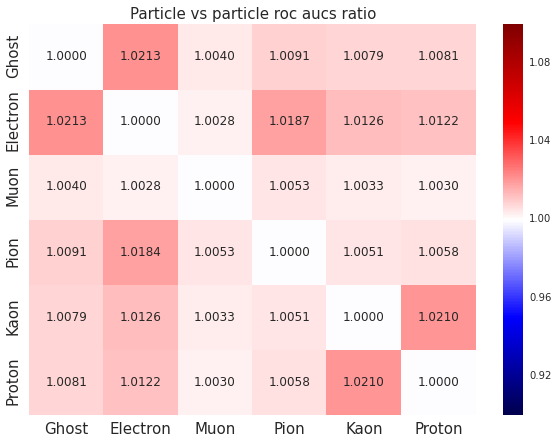

,Ghost,Electron,Muon,Pion,Kaon,Proton
Ghost,1.000000,1.021322,1.004029,1.009061,1.007907,1.008072
Electron,1.021323,1.000000,1.002785,1.018688,1.012598,1.012168
Muon,1.004029,1.002782,1.000000,1.005347,1.003345,1.002956
Pion,1.009061,1.018354,1.005322,1.000000,1.005080,1.005783
Kaon,1.007907,1.012632,1.003345,1.005080,1.000000,1.020967
Proton,1.008072,1.012163,1.002956,1.005782,1.020967,1.000000


In [ ]:
utils.get_roc_auc_ratio_matrix(roc_auc_matrix, roc_auc_matrix_baseline, save_path=new_work_path, show=True)

### Flatness

In [ ]:
%%time
flatness = utils.get_flatness_table(data_eval, labels_eval, proba_eval, particles, save_path=new_work_path)

In [73]:
flatness

,TrackP,TrackPt,P_Conf_level,Pt_Conf_level
Ghost,0.004112,0.014707,0.000865,0.000873
Electron,0.009779,0.032027,0.001045,0.000992
Muon,0.030532,0.046995,0.000914,0.000888
Pion,0.017858,0.014998,0.000847,0.000850
Kaon,0.046889,0.030953,0.000879,0.000869
Proton,0.035915,0.042077,0.000885,0.000875


In [74]:
flatness[['TrackP', 'TrackPt']].values.mean()

0.027236903959872064

In [75]:
flatness_baseline = pandas.read_csv("../python/flatness_baseline.csv", index_col=0)
flatness_baseline

,TrackP,TrackPt,P_Conf_level,Pt_Conf_level
Electron,0.006546,0.016579,0.001014,0.001004
Proton,0.034632,0.044571,0.000886,0.000888
Pion,0.016512,0.013729,0.000853,0.000851
Muon,0.020388,0.044991,0.000905,0.000906
Kaon,0.043074,0.036657,0.000872,0.000880
Ghost,0.006591,0.014187,0.000871,0.000870


In [76]:
utils.get_flatness_ratio(flatness, flatness_baseline, save_path=new_work_path)

,TrackP,TrackPt
Ghost,0.623962,1.036638
Electron,1.493927,1.931784
Muon,1.497555,1.044537
Pion,1.081541,1.092429
Kaon,1.088581,0.844390
Proton,1.037053,0.944028


### Efficiency curves

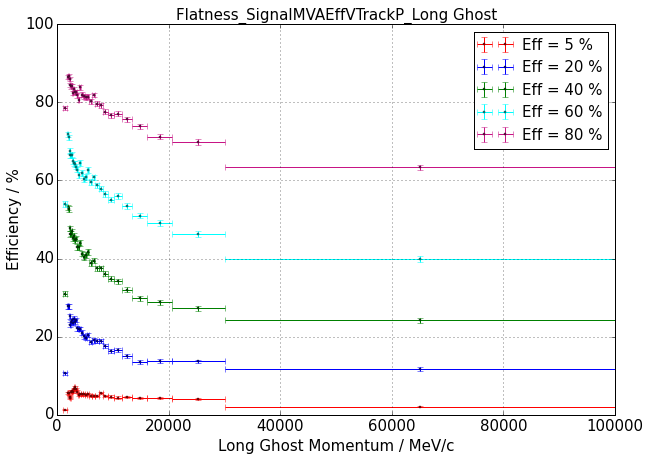

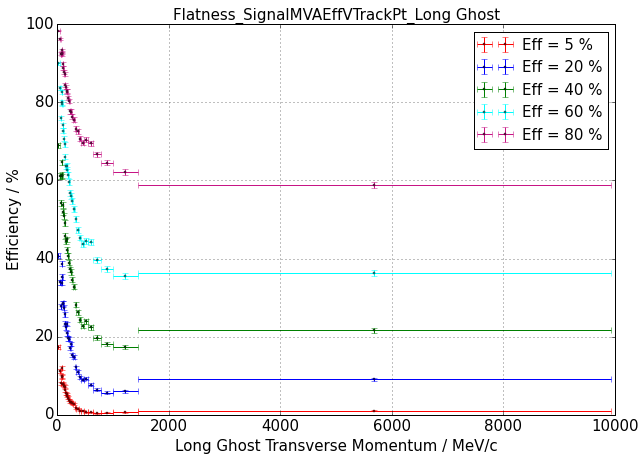

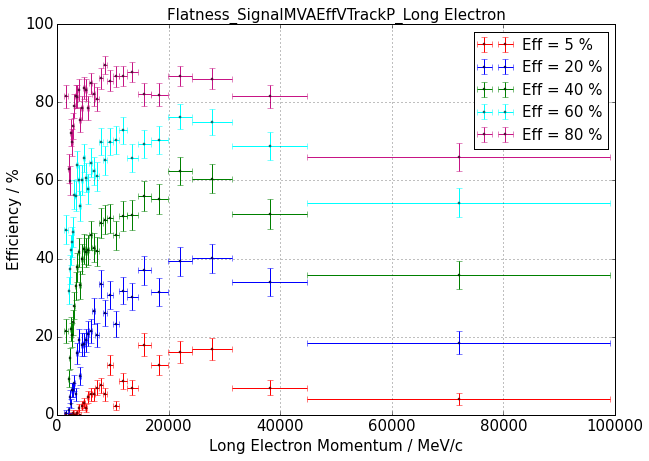

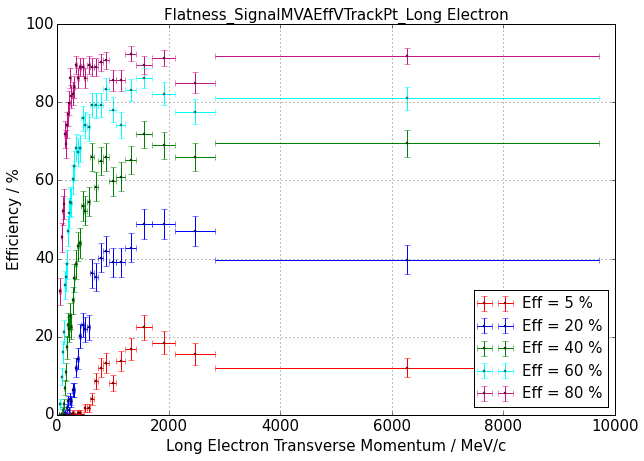

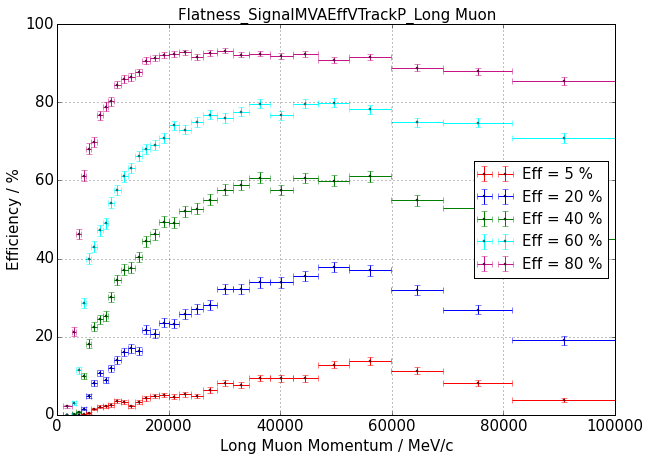

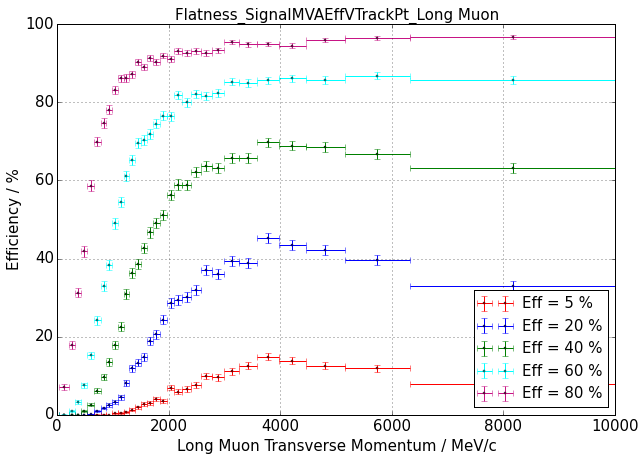

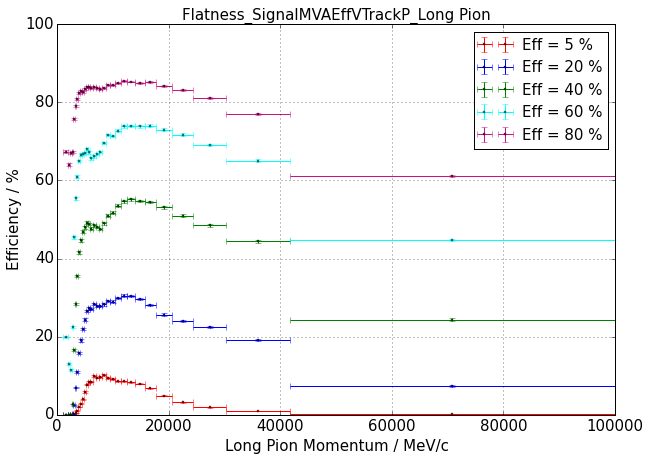

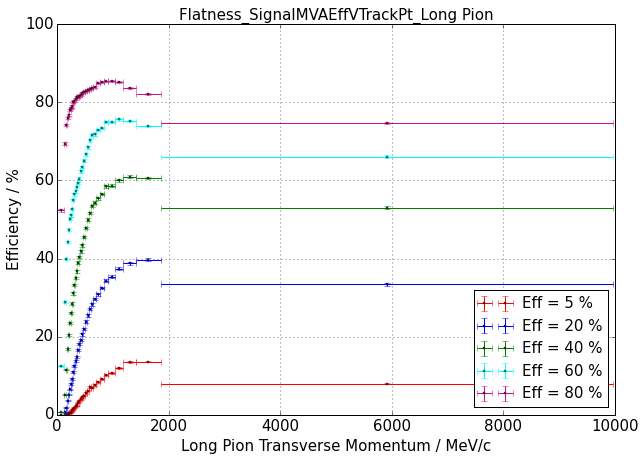

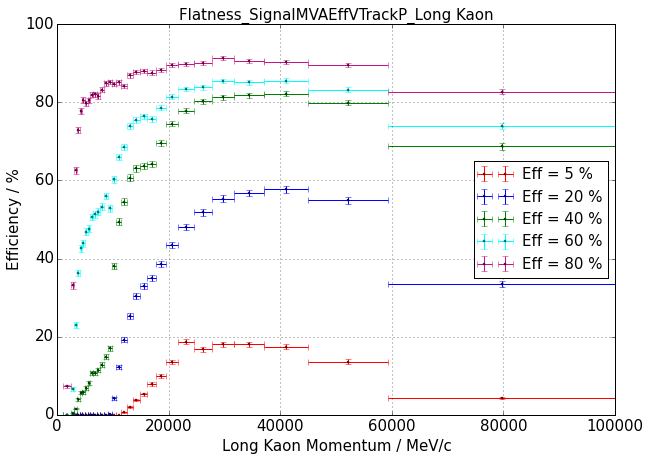

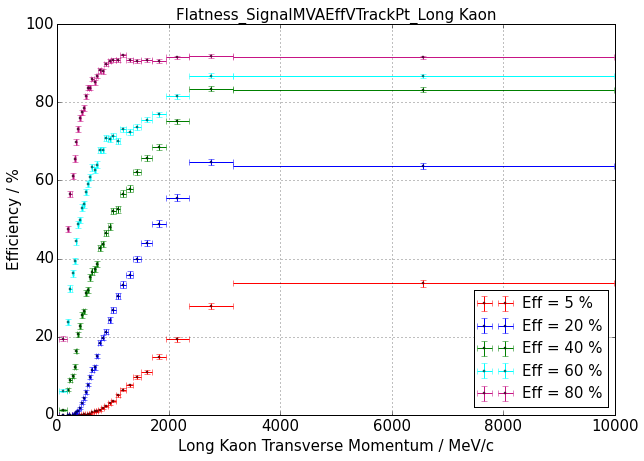

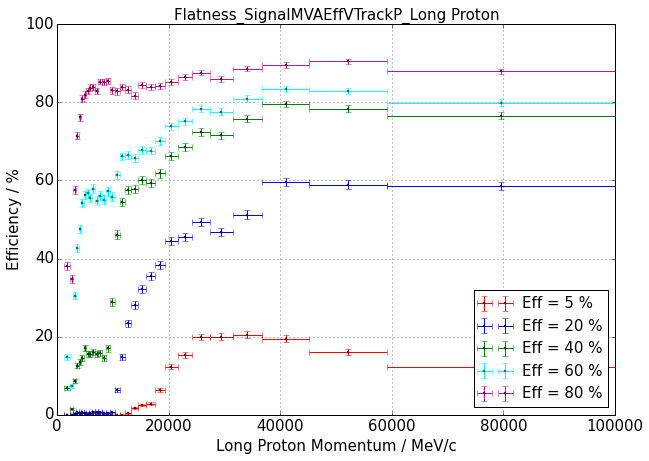

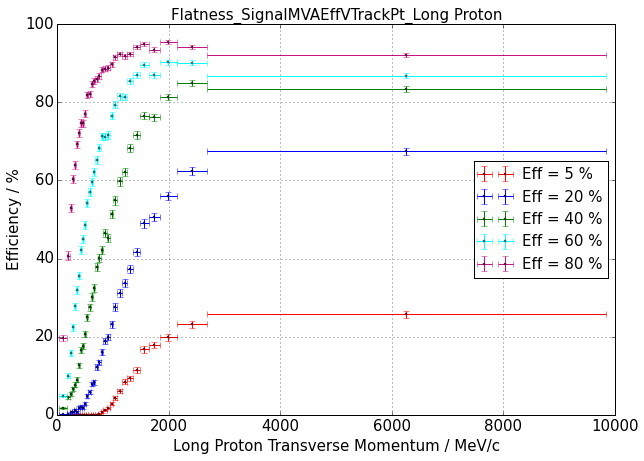

In [77]:
utils.get_all_flatness_figures(data_eval, proba_eval, labels_eval, 'Long', particles, save_path=new_work_path, show=True)